In [1]:
import sys
import geopandas as gpd
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

sys.path.append('../utils')
import data_paths
from gridding import GriddingEngine

# Import data

In [2]:
year = '2019'

inventory_path = data_paths.INVENTORY_FOLDER_PATH
em_hot = gpd.read_file(inventory_path + f'linesource_munich_{year}.gpkg')
em_cold = gpd.read_file(inventory_path + f'linesource_munich_{year}_cold.gpkg')

# Grid inventory and combine results

In [3]:
# import grid
tno_grid = gpd.read_file(data_paths.TNO_100M_GRID)
gridding_obj = GriddingEngine(input_grid=tno_grid, crs = em_hot.crs) # hot and cold inventory have the same crs

vehicle_classes_hot = ['PC', 'MOT', 'HGV', 'LCV', 'BUS']
vehicle_classes_cold = ['PC', 'LCV']

components = ['CO', 'NOx', 'PM', 'CO2(rep)', 'CO2(total)', 
                  'NO2', 'CH4', 'BC (exhaust)', 'CO2e']

em_hot_columns = [f'{v}_{c}' for v in vehicle_classes_hot for c in components]
em_cold_columns = [f'{v}_{c}' for v in vehicle_classes_cold for c in components]

out_grid_hot = gridding_obj.overlay_grid(em_hot, value_columns= em_hot_columns, source_type='line')
out_grid_cold = gridding_obj.overlay_grid(em_cold, value_columns= em_cold_columns, source_type='line')

aggregated_result = pd.DataFrame()
for c in components: 
    hot_cols_to_sum = [f'{v}_{c}' for v in vehicle_classes_hot]
    cold_cols_to_sum = [f'{v}_{c}' for v in vehicle_classes_cold]
    aggregated_result[c] = out_grid_hot[hot_cols_to_sum].sum(axis = 1)
    aggregated_result[c] = out_grid_cold[cold_cols_to_sum].sum(axis = 1) + aggregated_result[c]

aggregated_result['geometry'] = out_grid_hot['geometry']
aggregated_result['geometry'] = out_grid_cold['geometry']
aggregated_result = gpd.GeoDataFrame(data= aggregated_result, geometry='geometry', crs = em_hot.crs)

# Plot results

/var/folders/5v/yv2xq6j56r5459_qjzrm79rw0000gn/T/ipykernel_11062/2482471041.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap= matplotlib.cm.get_cmap('twilight_shifted'),


<Axes: >

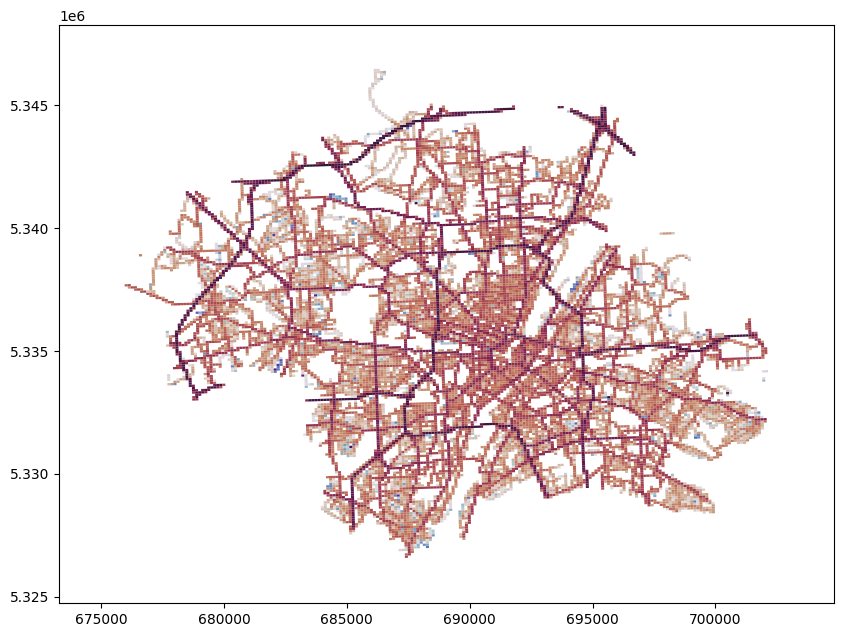

In [4]:
# plot results
fig, ax  = plt.subplots(figsize = (10,10), frameon=False)
aggregated_result.plot(ax= ax,
                column= 'CO2(rep)',
                cmap= matplotlib.cm.get_cmap('twilight_shifted'),
                norm= matplotlib.colors.LogNorm())

# Save results

In [5]:
path = data_paths.INVENTORY_FOLDER_PATH
#aggregated_result.to_file(path+f'GNFR_F_{year}.gpkg', driver = 'GPKG')

print(f'Total Emissions of {year}')
aggregated_result.sum(numeric_only=True)*1e-12

Total Emissions of 2019


CO                 3.860898
NOx                3.122529
PM                 0.046771
CO2(rep)        1154.345048
CO2(total)      1212.979843
NO2                0.547491
CH4                0.061635
BC (exhaust)       0.026549
CO2e            1169.313806
dtype: float64